In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
"""
https://github.com/inmcm/present_cipher/tree/master/python
"""
# coding: utf-8
from __future__ import print_function

s_box = (0xC, 0x5, 0x6, 0xB, 0x9, 0x0, 0xA, 0xD, 0x3, 0xE, 0xF, 0x8, 0x4, 0x7, 0x1, 0x2)

inv_s_box = (0x5, 0xE, 0xF, 0x8, 0xC, 0x1, 0x2, 0xD, 0xB, 0x4, 0x6, 0x3, 0x0, 0x7, 0x9, 0xA)

p_layer_order = [0, 16, 32, 48, 1, 17, 33, 49, 2, 18, 34, 50, 3, 19, 35, 51, 4, 20, 36, 52, 5, 21, 37, 53, 6, 22, 38,
                 54, 7, 23, 39, 55, 8, 24, 40, 56, 9, 25, 41, 57, 10, 26, 42, 58, 11, 27, 43, 59, 12, 28, 44, 60, 13,
                 29, 45, 61, 14, 30, 46, 62, 15, 31, 47, 63]

block_size = 64

ROUND_LIMIT = 32


def round_function(state, key):
    new_state = state ^ key
    state_nibs = []
    for x in range(0, block_size, 4):
        nib = (new_state >> x) & 0xF
        sb_nib = s_box[nib]
        state_nibs.append(sb_nib)
    # print(state_nibs)

    state_bits = []
    for y in state_nibs:
        nib_bits = [1 if t == '1'else 0 for t in format(y, '04b')[::-1]]
        state_bits += nib_bits
    # print(state_bits)
    # print(len(state_bits))

    state_p_layer = [0 for _ in range(64)]
    for p_index, std_bits in enumerate(state_bits):
        state_p_layer[p_layer_order[p_index]] = std_bits

    # print(len(state_p_layer), state_p_layer)

    round_output = 0
    for index, ind_bit in enumerate(state_p_layer):
        round_output += (ind_bit << index)

    # print(format(round_output, '#016X'))

    # print('')
    return round_output


def key_function_80(key, round_count):
    # print('Start: ', hex(key))
    # print('')

    r = [1 if t == '1'else 0 for t in format(key, '080b')[::-1]]

    # print('k bits:', r)
    # print('')

    h = r[-61:] + r[:-61]

    # print('s bits:', h)
    # print('')

    round_key_int = 0
    # print('init round int:', hex(round_key_int))
    for index, ind_bit in enumerate(h):
        round_key_int += (ind_bit << index)
        # print('round:',index, '-', hex(round_key_int))

    # print('round_key_int', hex(round_key_int))
    # print('')

    upper_nibble = round_key_int >> 76

    # print('upper_nibble:', upper_nibble)

    upper_nibble = s_box[upper_nibble]

    # print('upper_nibble sboxed', hex(upper_nibble))

    xor_portion = ((round_key_int >> 15) & 0x1F) ^ round_count
    # print('Count:', round_count)
    # print('XOR Value:', xor_portion)

    # print('Before:', hex(round_key_int))
    round_key_int = (round_key_int & 0x0FFFFFFFFFFFFFF07FFF) + (upper_nibble << 76) + (xor_portion << 15)
    # print('After: ', hex(round_key_int))

    return round_key_int



test_vectors_80 = {1:(0x00000000000000000000, 0x0000000000000000, 0x5579C1387B228445),
                2:(0xFFFFFFFFFFFFFFFFFFFF, 0x0000000000000000, 0xE72C46C0F5945049),
                3:(0x00000000000000000000, 0xFFFFFFFFFFFFFFFF, 0xA112FFC72F68417B),
                4:(0xFFFFFFFFFFFFFFFFFFFF, 0xFFFFFFFFFFFFFFFF, 0x3333DCD3213210D2)}
        
def PRESENT(P, K, ROUND):
    key_schedule = []
    current_round_key = K
    round_state = P
    
    if(ROUND==0):
        return P

    for rnd_cnt in range(ROUND):
        key_schedule.append(current_round_key >> 16)
        current_round_key = key_function_80(current_round_key, rnd_cnt + 1)

    for rnd in range(ROUND - 1):
        round_state = round_function(round_state, key_schedule[rnd])

    round_state ^= key_schedule[ROUND-1]
    
    return round_state

In [3]:
Wang_diff = [0x7000000000007000, 0x0700000000000700, 0x0070000000000070, 0x0007000000000007]
BLOCK_SIZE = 64
sample_num = 10000

In [4]:
def gen(sample_num, ROUND):
    P_set = []
    K_set = []
    for i in range(sample_num):
        P_set.append(random.randrange(0,2**64))
        #print("%x" % P_set[i])
        K_set.append(random.randrange(0,2**80))
        #print("%x" % K_set[i])

    C_diff_set = []
    C_diff_label = []
    for i in range(sample_num):
        P = P_set[i]
        K = K_set[i]
        C = PRESENT(P, K, ROUND)
        for j in range(4):
            Cj = PRESENT(P^Wang_diff[j], K, ROUND)
            C_diff = C^Cj
            #print(C_diff)
            C_diff_set.append(C_diff)
            temp = [0, 0, 0, 0]
            temp[j] = 1
            C_diff_label.append(temp)

    tr_X = []
    for C_diff in C_diff_set:
        A = []
        for j in range(BLOCK_SIZE):
            A.append((C_diff>>j)&1)
        tr_X.append(A)
        #print(A)
    tr_X = np.array(tr_X)

    tr_X = []
    for C_diff in C_diff_set:
        A = []
        for j in range(BLOCK_SIZE):
            A.append((C_diff>>j)&1)
        tr_X.append(A)
        #print(A)
    tr_X = np.array(tr_X)
    tr_t = np.array(C_diff_label)

    ind = np.arange(len(tr_X))
    np.random.shuffle(ind)
    tr_X = tr_X[ind]
    tr_t = tr_t[ind]
    
    return tr_X, tr_t

In [5]:
def sample_gen():
    SAMPLE_NUM_RANGE = [10000, 50000, 100000]
    ROUND_RANGE = [3, 4, 5, 6, 7, 8]
    for sn in SAMPLE_NUM_RANGE:
        for rn in ROUND_RANGE:
            tr_X, tr_t = gen(sn, rn)
            np.save("ROUND %d SAMPLE %d Dataset" % (rn, sn), tr_X)
            np.save("ROUND %d SAMPLE %d Label" % (rn, sn), tr_t)

def test_sample_gen():
    TEST_SMAPLE_NUM = 10000
    for rn in ROUND_RANGE:
        te_X, te_t = gen(TEST_SMAPLE_NUM, rn)
        np.save("ROUND %d TEST_SAMPLE Dataset" % (rn), te_X)
        np.save("ROUND %d TEST_SAMPLE Label" % (rn), te_t)
        
def load_sample(SAMPLE_NUM, ROUND_NUM):
    tr_X = np.load("ROUND %d SAMPLE %d Dataset.npy" % (ROUND_NUM, SAMPLE_NUM))
    tr_t = np.load("ROUND %d SAMPLE %d Label.npy" % (ROUND_NUM, SAMPLE_NUM))
    return tr_X, tr_t

def load_test_sample(ROUND_NUM):
    te_X = np.load("ROUND %d TEST_SAMPLE Dataset.npy" % (ROUND_NUM))
    te_t = np.load("ROUND %d TEST_SAMPLE Label.npy" % (ROUND_NUM))
    return te_X, te_t

In [6]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


class MLP:
    def __init__(self, layer1=128, layer2=1028, layer3=None, reg=None, learning_rate=0.001):
        self.layers = self._build_layers(layer1, layer2, layer3, reg)
        self.model = tf.keras.Sequential(self.layers) 
        self.model.compile(optimizer=tf.keras.optimizers.Adam(lr=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

    def _build_layers(self, layer1, layer2, layer3, reg):
        if layer3==None:
            layers = [
                tf.keras.layers.Flatten(input_shape=(64,)),
                tf.keras.layers.Dense(layer1, activation='relu', kernel_regularizer=reg),
                tf.keras.layers.Dense(layer2, activation='relu', kernel_regularizer=reg),
                #tf.keras.layers.Dense(layer3, activation='relu', kernel_regularizer=reg),
                tf.keras.layers.Dense(4, activation='softmax')
            ]
        else:
            layers = [
                tf.keras.layers.Flatten(input_shape=(64,)),
                tf.keras.layers.Dense(layer1, activation='relu', kernel_regularizer=reg),
                tf.keras.layers.Dense(layer2, activation='relu', kernel_regularizer=reg),
                tf.keras.layers.Dense(layer3, activation='relu', kernel_regularizer=reg),
                tf.keras.layers.Dense(4, activation='softmax')
            ]
        return layers

    #그냥 cross entropy를 그대로 정의함
    def _my_loss(self, y_true, y_pred):
        y_true = tf.cast(y_true, tf.int32) #float32 => int32로 casting #None, 1
        y_true = tf.squeeze(tf.one_hot(y_true, depth=10, dtype=tf.float32), 1) # one_hot encoding #None, 1, 10 #quezze => 1을 없애줌 => None, 10
        y_pred = tf.nn.softmax(y_pred, 1) # 한 축에 대해 softmax를 적용해라 #1 => 열을 의미 #즉, 한 행에 있는 값을 다 더하면 1이 되도록 만들어줌

        #cross entropy 그대로 적용
        #-sum t*log y 한 후에 평균 냄
        return -tf.reduce_mean(tf.reduce_sum(
                tf.multiply(y_true, tf.math.log(y_pred)), 1))

    def _my_accuracy(self, y_true, y_pred):
        y_true = tf.cast(y_true, tf.int32)
        y_true = tf.squeeze(tf.one_hot(y_true, depth=10, dtype=tf.float32), 1)
        #argmax를 그대로 이용
        return tf.reduce_mean(
            tf.cast(
                tf.equal(tf.argmax(y_true, 1), tf.argmax(y_pred, 1)), tf.float32))

    def fit(self, x, t, epochs, batch_size=None, validation_split=0.0, verbose=1, shuffle=False, workers=2):
        return self.model.fit(x, t, epochs=epochs, batch_size=batch_size, validation_split=validation_split, verbose=verbose, shuffle=shuffle, workers=workers)
    
    def evaluate(self, x=None, y=None, verbose=1):
        return self.model.evaluate(x=x, y=y, verbose=verbose)
    
    def summary(self):
        self.model.summary()

In [7]:
#Config
ROUND = 6
SAMPLE_NUM = 10000
ITERATION = 2

#Fix
batch_size = 200
epoch_size = 25
validation_split = 0.3 #no meaning, but to make it same with base paper

weight_L1 = 0.00012
layer1 = 256
layer2 = 2048
reg = tf.keras.regularizers.L1(weight_L1)


learning_rate = 0.001

In [8]:
def learn(ROUND=ROUND, SAMPLE_NUM=SAMPLE_NUM, layer1=layer1, layer2=layer2, layer3=None, reg=reg, learning_rate=0.001, verbose=0):
    tr_X, tr_t = load_sample(SAMPLE_NUM=SAMPLE_NUM, ROUND_NUM=ROUND)
    te_X, te_t = load_test_sample(ROUND_NUM=ROUND)
    accuracy = []
    for i in range(ITERATION):
        model = MLP(layer1, layer2, layer3, reg, learning_rate)
        results = model.fit(tr_X, tr_t, epochs=epoch_size, batch_size=batch_size, validation_split = validation_split, shuffle=True, verbose=verbose)
        best_val_acc = max(results.history['val_accuracy'])
        accuracy.append(best_val_acc)
    avg = np.mean(np.array(accuracy))
    #print("average : %f" % avg)
    return avg

In [9]:
start = 0.0001
end = 0.005
step = 0.0001
lr_cand = np.arange(start, end, step)

In [10]:
print(lr_cand)

[0.0001 0.0002 0.0003 0.0004 0.0005 0.0006 0.0007 0.0008 0.0009 0.001
 0.0011 0.0012 0.0013 0.0014 0.0015 0.0016 0.0017 0.0018 0.0019 0.002
 0.0021 0.0022 0.0023 0.0024 0.0025 0.0026 0.0027 0.0028 0.0029 0.003
 0.0031 0.0032 0.0033 0.0034 0.0035 0.0036 0.0037 0.0038 0.0039 0.004
 0.0041 0.0042 0.0043 0.0044 0.0045 0.0046 0.0047 0.0048 0.0049]


In [11]:
accuracy = []
for lr in lr_cand:
    acc = learn(learning_rate=lr)
    accuracy.append(acc)
    print("lr %f\t : %f" % (lr, acc))

lr 0.000100	 : 0.260625
lr 0.000200	 : 0.263250
lr 0.000300	 : 0.260625
lr 0.000400	 : 0.260083
lr 0.000500	 : 0.261708
lr 0.000600	 : 0.260667
lr 0.000700	 : 0.261333
lr 0.000800	 : 0.262667
lr 0.000900	 : 0.260667
lr 0.001000	 : 0.262625
lr 0.001100	 : 0.261417
lr 0.001200	 : 0.258917
lr 0.001300	 : 0.258708
lr 0.001400	 : 0.258458
lr 0.001500	 : 0.258458
lr 0.001600	 : 0.259292
lr 0.001700	 : 0.258625
lr 0.001800	 : 0.258292
lr 0.001900	 : 0.258917
lr 0.002000	 : 0.258708
lr 0.002100	 : 0.257417
lr 0.002200	 : 0.257500
lr 0.002300	 : 0.257458
lr 0.002400	 : 0.255958
lr 0.002500	 : 0.257167
lr 0.002600	 : 0.257333
lr 0.002700	 : 0.257500
lr 0.002800	 : 0.253833
lr 0.002900	 : 0.254125
lr 0.003000	 : 0.253833
lr 0.003100	 : 0.253833
lr 0.003200	 : 0.259083
lr 0.003300	 : 0.253833
lr 0.003400	 : 0.252208
lr 0.003500	 : 0.256542
lr 0.003600	 : 0.253833
lr 0.003700	 : 0.253833
lr 0.003800	 : 0.253833
lr 0.003900	 : 0.253833
lr 0.004000	 : 0.253833
lr 0.004100	 : 0.253833
lr 0.004200	 : 0

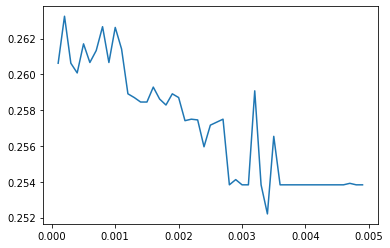

In [12]:
plt.plot(lr_cand, accuracy)

In [13]:
print(max(accuracy))
idx = accuracy.index(max(accuracy))
print(lr_cand[idx])

0.2632499933242798
0.0002
